[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/4b_vit_cifar10.ipynb)

# Aplicaciones de Transformers (ViT)

---
Curso: Aprendizaje Profundo.

Profesor: Gibran Fuentes Pineda.

Ayudantes: Fernando Nava y Rodrigo del Moral

---

En esta libreta veremos una aplicación de bloques Transformers basada en https://arxiv.org/abs/2010 para clasificación de imágenes.

## 1. Preparación

In [ ]:
!pip install einops
!pip install -q torchinfo

## 1.1 Bibliotecas

In [ ]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
# cargador de datos
from torch.utils.data import DataLoader
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image

from einops import rearrange, repeat


## 1.3 Funciones Auxiliares

In [ ]:
# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


#def timestamp(fmt='%y%m%dT%H%M%S'):
#    """Regresa la marca de tiempo."""
#    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2. Dataset

In [ ]:
# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 128

In [ ]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    #T.CenterCrop(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
# transformación de validación
test_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    #T.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=trn_tsfm)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_tsfm)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Diccionario de etiqueta a la clase:
cls_idx = {i: c for i, c in enumerate(classes)}

# Función para pasar un lote de etiquetas a sus clases:
def names_batch(targets):
  cls_idxs = [cls_idx[y.item()] for y in targets]
  return cls_idxs

Files already downloaded and verified
Files already downloaded and verified


## 2.1. Dataloader

In [ ]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

### Entrenamiento

x shape=torch.Size([32, 3, 128, 128]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


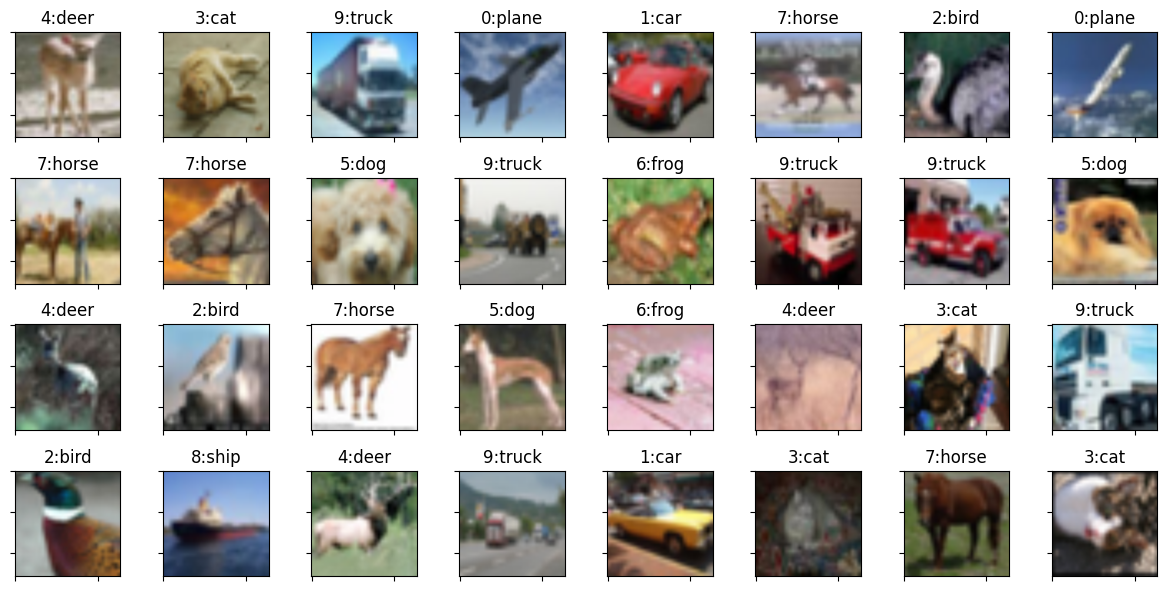

In [ ]:
# desplegamos lote
train_batch = next(iter(trainloader))
x, y = train_batch[0] , train_batch[1]
titles = [f'{v}:{l}' for v, l in zip(y, names_batch(y))]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

### Prueba

x shape=torch.Size([32, 3, 128, 128]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


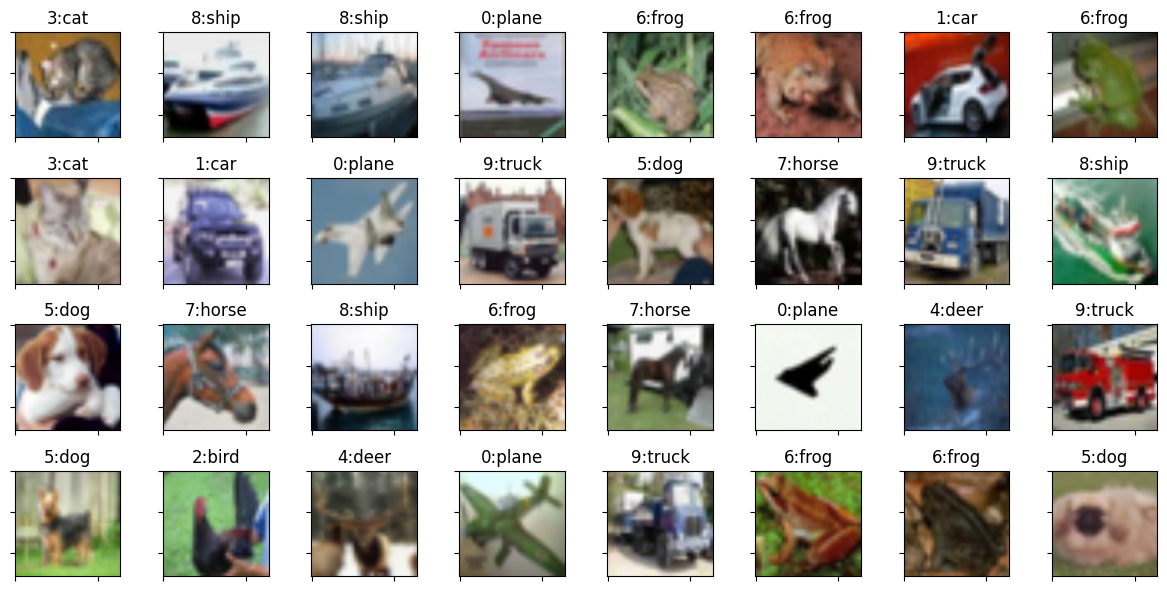

In [ ]:
# desplegamos lote
test_batch = next(iter(testloader))
x, y = test_batch[0] , test_batch[1]
titles = [f'{v}:{l}' for v, l in zip(y, names_batch(y))]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

## 3. Modelo

Se implementó la arquitectura Vision Transformer (ViT) propuesta en el artículo "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" que esta en: https://arxiv.org/abs/2010.11929


<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

Imagen tomada de https://arxiv.org/abs/2010

### 3.1. Multihead Attention

In [ ]:
class ProductoPuntoEscalado(nn.Module):
  def __init__(self,
               masc = False):
    super(ProductoPuntoEscalado, self).__init__()
    self.masc = masc

  def forward(self, Q, K, V):
    # Obtenemos dimensiones
    m, n_cabezas, l, d_k = K.shape
    d_v = V.shape[-1]

    # Cambiamos la forma: [m, n_cabezas, l, d_k] -> [m * n_cabezas, l, d_k]
    Q = Q.reshape(m * n_cabezas, l, d_k)
    K = K.reshape(m * n_cabezas, l, d_k)
    V = V.reshape(m * n_cabezas, l, d_v)

    # Q y K tienen forma [m * n_cabezas, l, d_k],
    # por lo que se transponen las dos últimas dimensiones de K
    # QK: [m * n_cabezas, l, l]
    QK = torch.bmm(Q, K.transpose(1, 2))

    # se escalan los valores QK
    QK_esc = QK / torch.math.sqrt(d_k)

    if self.masc:
      # Creamos una matriz triangular superior binaria (excluyendo la diagonal)
      masc = torch.triu(torch.ones((l, l), dtype = torch.bool, device = Q.device),
                     diagonal = 1)
      # Ponemos los valores de QK_esc en los que la máscara sea 1 a -inf
      QK_esc = QK_esc.masked_fill_(masc, -torch.inf)

    # mapas de atención: [m * n_cabezas, l, l] -> [m * n_cabezas, l, l]
    alfas = nn.functional.softmax(QK_esc, dim=-1)

    # vectores de salida y
    # alfas: [m * n_cabezas, l, l], V: [m * n_cabezas, l, d_v]
    # Y: [m * n_cabezas, l, d_v]
    Y = torch.bmm(alfas, V)

    # Cambiamos la forma: [m * n_cabezas, l, d_v] -> [m, n_cabezas, l, d_v]
    Y = Y.reshape(m, n_cabezas, l, d_v)

    # Cambiamos la forma: [m * n_cabezas, l, l] -> [m, n_cabezas, l, l]
    alfas = alfas.reshape(m, n_cabezas, l, l)

    return Y, alfas

In [ ]:
class AtencionMulticabeza(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               masc = False):
    super(AtencionMulticabeza, self).__init__()

    self.n_cabezas = n_cabezas
    self.d_modelo = d_modelo

    self.ppe = ProductoPuntoEscalado(masc = masc)
    self.proy_Q = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_K = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_V = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_sal = nn.Linear(self.d_modelo, self.d_modelo)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma del tensor x
    # [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Proyectamos vectores en x a Q, K, V
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Q = self.proy_Q(x)
    K = self.proy_K(x)
    V = self.proy_V(x)

    # Cambiamos la forma: [m * l, d_modelo] -> [m, l, n_cabezas, d_k]
    # d_k = d_v = self.d_modelo // self.n_cabezas
    Q = Q.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    K = K.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    V = V.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)

    # Transponemos el eje de las cabezas a la segunda posición del tensor y
    # creamos copia (con .contiguous()) para que esté almacenado en memoria de
    # forma contigua (.transpose() hace que ya no sea así).
    # [m, l, n_cabezas, d_k] -> [m, n_cabezas, l, d_k]
    Q = Q.transpose(1, 2).contiguous()
    K = K.transpose(1, 2).contiguous()
    V = V.transpose(1, 2).contiguous()

    # Calculamos el producto punto escalado con Q, K y V
    # Q, K: [m, n_cabezas, l, d_k], V:[m, n_cabezas, l, d_v]
    # Y: [m, n_cabezas, l, d_v], alfas: [m, n_cabezas, l, l]
    Y, alfas = self.ppe(Q, K, V)

    # Transponermos el eje de cabezas a la penúltima posición:
    # [m, n_cabezas, l, d_k] -> [m, l, n_cabezas, d_k]
    Y = Y.transpose(1, 2).contiguous()

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m, l, n_cabezas, d_k] -> [m * l, d_modelo]
    # d_modelo = n_cabezas * d_k
    Y = Y.reshape(m * l, self.d_modelo)

    # Proyectamos la vectores concatenados para obtener la salida
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Y = self.proy_sal(Y)

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m * l, d_modelo] -> [m, l, d_modelo]
    Y = Y.reshape(m, l, self.d_modelo)

    return Y, alfas

In [ ]:
amc = AtencionMulticabeza(32, 2)
amc(torch.ones([1, 256, 32]))[0].shape

torch.Size([1, 256, 32])

### 3.2. Bloque transformer ViT

<img src="https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png">

Imagen tomada de https://arxiv.org/abs/2010.11929


El MLP sería la RedDensaPosición vista en clase con algunas modificaciónes como la capa GELU y algunos Dropout

In [ ]:
class RedDensaPosicion(nn.Module):
  def __init__(self,
               d_modelo,
               d_ff,
               p_dropout):

    super(RedDensaPosicion, self).__init__()
    self.d_modelo = d_modelo
    self.d_ff = d_ff

    self.densa1 = nn.Linear(self.d_modelo, self.d_ff)
    self.densa2 = nn.Linear(self.d_ff, self.d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)
    self.dropout2 = nn.Dropout(p_dropout)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma: [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Pasamos el tensor redimensionado por la red densa
    # [m * l, d_modelo] -> [m * l, d_modelo]
    x = self.densa1(x)
    x = nn.functional.gelu(x)
    x = self.dropout1(x)

    x = self.densa2(x)
    x = self.dropout2(x)

    # Lo regresamos a su forma original
    # [m * l, d_modelo] -> [m, l, d_modelo]
    x = x.reshape(m, l, d_modelo)

    return x

In [ ]:
class BloqueTransformer(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               d_rdp,
               p_dropout = 0.0,
               masc = False):
    super(BloqueTransformer, self).__init__()

    self.amc = AtencionMulticabeza(d_modelo = d_modelo,
                                   n_cabezas = n_cabezas,
                                   masc = masc)
    self.norm1 = nn.LayerNorm(d_modelo)
    self.norm2 = nn.LayerNorm(d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)

    self.mlp = RedDensaPosicion(d_modelo, d_rdp, p_dropout)

  def forward(self, x):
    x_ln1 = self.norm1(x)
    salidas_amc, alfas = self.amc(x_ln1)
    salidas_amc = self.dropout1(salidas_amc)

    x = salidas_amc + x
    x_ln2 = self.norm2(x)
    mlp = self.mlp(x_ln2)
    out = mlp + x

    return out

In [ ]:
test_layer = BloqueTransformer(64, 2, 256)
test_layer(torch.ones([1, 64, 64])).shape

torch.Size([1, 64, 64])

In [ ]:
summary(test_layer, (1, 64, 64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
BloqueTransformer                        [1, 64, 64]               --
├─LayerNorm: 1-1                         [1, 64, 64]               128
├─AtencionMulticabeza: 1-2               [1, 64, 64]               --
│    └─Linear: 2-1                       [64, 64]                  4,096
│    └─Linear: 2-2                       [64, 64]                  4,096
│    └─Linear: 2-3                       [64, 64]                  4,096
│    └─ProductoPuntoEscalado: 2-4        [1, 2, 64, 32]            --
│    └─Linear: 2-5                       [64, 64]                  4,160
├─Dropout: 1-3                           [1, 64, 64]               --
├─LayerNorm: 1-4                         [1, 64, 64]               128
├─RedDensaPosicion: 1-5                  [1, 64, 64]               --
│    └─Linear: 2-6                       [64, 256]                 16,640
│    └─Dropout: 2-7                      [64, 256]                 

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, d_modelo,
                 depth, n_cabezas, mlp_dim, dropout):
        super().__init__()
        self.d_modelo = d_modelo

        # N = H*W/(P^2)
        self.n_patches = (img_size // patch_size) ** 2

        input_projection = 3*(patch_size ** 2) # C*PP

        self.projection = nn.Linear(input_projection, d_modelo) #

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, d_modelo))


        self.cls_token = nn.Parameter(torch.randn(1, 1, d_modelo))

        bloques = [BloqueTransformer(d_modelo,
                                     n_cabezas,
                                     mlp_dim,
                                     dropout,
                                     masc = False) for _ in range(depth)]
        self.transformer = nn.Sequential(*bloques)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_modelo),
            nn.Linear(d_modelo, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]

        # Patches
        # N x (P^2 * C)
        # Donde:
        # N = HW/P^2

        #img_patches0 = x.reshape(B, self.n_patches, int((patch_size*patch_size)*C))

        img_patches = rearrange(x,
                        'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                        patch_x=patch_size, patch_y=patch_size)

        # Linear Projection
        x = self.projection(img_patches)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0, :]
        return self.mlp_head(x)

In [ ]:
#'''
patch_size = 16
out_dim = 10
d_modelo = 64
depth = 3

n_cabezas = 4
mlp_dim = 256
dropout = 0.5


vit = ViT(IMG_SIZE, patch_size, out_dim, d_modelo, depth, n_cabezas, mlp_dim, dropout)
test_out = vit(train_batch[0])
test_out.shape
#'''

torch.Size([32, 10])

In [ ]:
summary(vit, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu')


Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 10]                   4,224
├─Linear: 1-1                                      [1, 64, 64]               49,216
├─Sequential: 1-2                                  [1, 65, 64]               --
│    └─BloqueTransformer: 2-1                      [1, 65, 64]               --
│    │    └─LayerNorm: 3-1                         [1, 65, 64]               128
│    │    └─AtencionMulticabeza: 3-2               [1, 65, 64]               16,448
│    │    └─Dropout: 3-3                           [1, 65, 64]               --
│    │    └─LayerNorm: 3-4                         [1, 65, 64]               128
│    │    └─RedDensaPosicion: 3-5                  [1, 65, 64]               33,088
│    └─BloqueTransformer: 2-2                      [1, 65, 64]               --
│    │    └─LayerNorm: 3-6                         [1, 65, 64]               128
│    │    └─Atenc

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
vit = vit.to(device)

## 4. Funciones de Entrenamiento y Evaluación

In [ ]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    # entrenamiento de una época
    for batch in dl:
        x = batch[0].to(device)
        y_true = batch[1].to(device)
        # computamos logits
        y_lgts = model(x)

        # Para obtener el Accuracy:
        # computamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # computamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    trn_loss = epoch_loss / len(dl)
    trn_acc = epoch_acc / len(dl)

    return trn_loss, trn_acc

In [ ]:
def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""

    # Modelo en modo de evaluación
    # Congelar las estadísticas σ y μ
    model.eval()

    # evitamos que se registren las operaciones
    # en la gráfica de cómputo
    with torch.no_grad():

        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch[0].to(device)
            y_true = batch[1].to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses)
        acc = np.mean(accs)

        return loss, acc

In [ ]:
def train(model, trn_dl, val_dl, epochs,
          trn_batches=None, val_batches=None):

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    # optimizador
    opt = optim.Adam(model.parameters(), lr=0.0001)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        trn_loss , trn_acc = train_epoch(trn_dl, model, opt, device)
        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)

        train_losses.append(trn_loss)
        val_losses.append(val_loss)

        train_accs.append(trn_acc)
        val_accs.append(val_acc)

        print(f'\nEpoch {epoch}: Train loss: {trn_loss:4f} Train Accuracy: {trn_acc:4f}')
        print(f'Val loss: {val_loss:4f} Val Accuracy: {val_acc:4f}')

    return train_losses, val_losses, train_accs, val_accs

## 4.1. Entrenamiento

In [ ]:
# entrenamos modelo
model = vit
train_losses, val_losses, train_accs, val_accs =train(model, trainloader, testloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 0: Train loss: 1.915993 Train Accuracy: 0.310041
Val loss: 1.757417 Val Accuracy: 0.377895

Epoch 1: Train loss: 1.754691 Train Accuracy: 0.374940
Val loss: 1.680272 Val Accuracy: 0.407149

Epoch 2: Train loss: 1.679506 Train Accuracy: 0.402551
Val loss: 1.614696 Val Accuracy: 0.425220

Epoch 3: Train loss: 1.617512 Train Accuracy: 0.423604
Val loss: 1.545297 Val Accuracy: 0.449281

Epoch 4: Train loss: 1.562731 Train Accuracy: 0.439659
Val loss: 1.503863 Val Accuracy: 0.462760

Epoch 5: Train loss: 1.526004 Train Accuracy: 0.455054
Val loss: 1.467753 Val Accuracy: 0.474541

Epoch 6: Train loss: 1.493244 Train Accuracy: 0.465051
Val loss: 1.447885 Val Accuracy: 0.484026

Epoch 7: Train loss: 1.465137 Train Accuracy: 0.478347
Val loss: 1.437689 Val Accuracy: 0.483427

Epoch 8: Train loss: 1.442456 Train Accuracy: 0.483885
Val loss: 1.412469 Val Accuracy: 0.497105

Epoch 9: Train loss: 1.425126 Train Accuracy: 0.492222
Val loss: 1.384816 Val Accuracy: 0.509385

Epoch 10: Train los

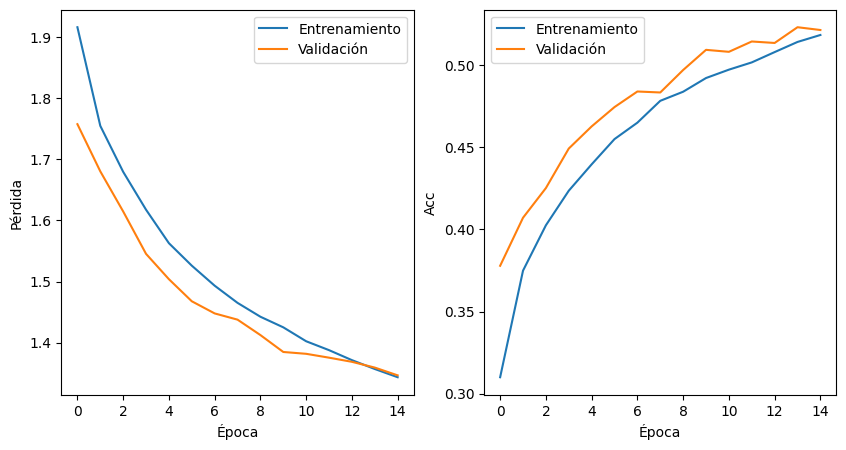

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(train_losses, label='Entrenamiento')
axs[0].plot(val_losses, label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(train_accs, label='Entrenamiento')
axs[1].plot(val_accs, label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Acc')
axs[1].legend()
plt.show()

## 4.2. Evaluación

In [ ]:
device2 = torch.device('cpu')
trn_loss, trn_acc = eval_epoch(trainloader, model.to(device2), device2)
tst_loss, tst_acc = eval_epoch(testloader, model.to(device2), device2)

print(f'trn_acc={trn_acc:5.2f} tst_acc={tst_acc:5.2f}')
print(f'trn_loss={trn_loss:6.2f} tst_loss={tst_loss:6.2f}')

trn_acc= 0.54 tst_acc= 0.52
trn_loss=  1.29 tst_loss=  1.35


## 4.3. Evaluación de cada clase

In [ ]:
# Diccionarios para contar las predicciones de cada clase
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = vit(images)
        _, predictions = torch.max(outputs, 1)
        # Obtenemos la predicción correcta para cada clase
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Accuracy para cada clase
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.5 %
Accuracy for class: car   is 57.3 %
Accuracy for class: bird  is 39.3 %
Accuracy for class: cat   is 23.0 %
Accuracy for class: deer  is 43.5 %
Accuracy for class: dog   is 50.2 %
Accuracy for class: frog  is 60.3 %
Accuracy for class: horse is 61.6 %
Accuracy for class: ship  is 72.4 %
Accuracy for class: truck is 56.4 %


## 4.4. Visualizar Resultados

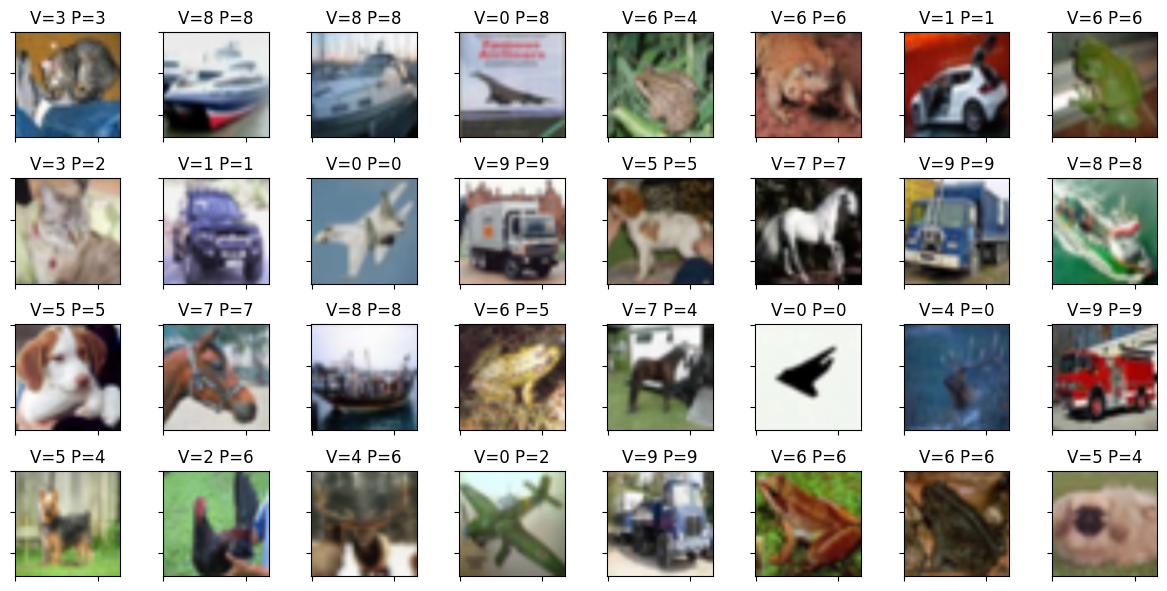

In [ ]:
device2 = torch.device('cpu')
with torch.no_grad():
    batch = next(iter(testloader))
    x, y_true = batch[0].to(device2), batch[1].to(device2)

    y_pred = torch.argmax(F.softmax(model(x.to(device2)).to(device), 1), 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x.to(device2), titles, ROWS, COLS)

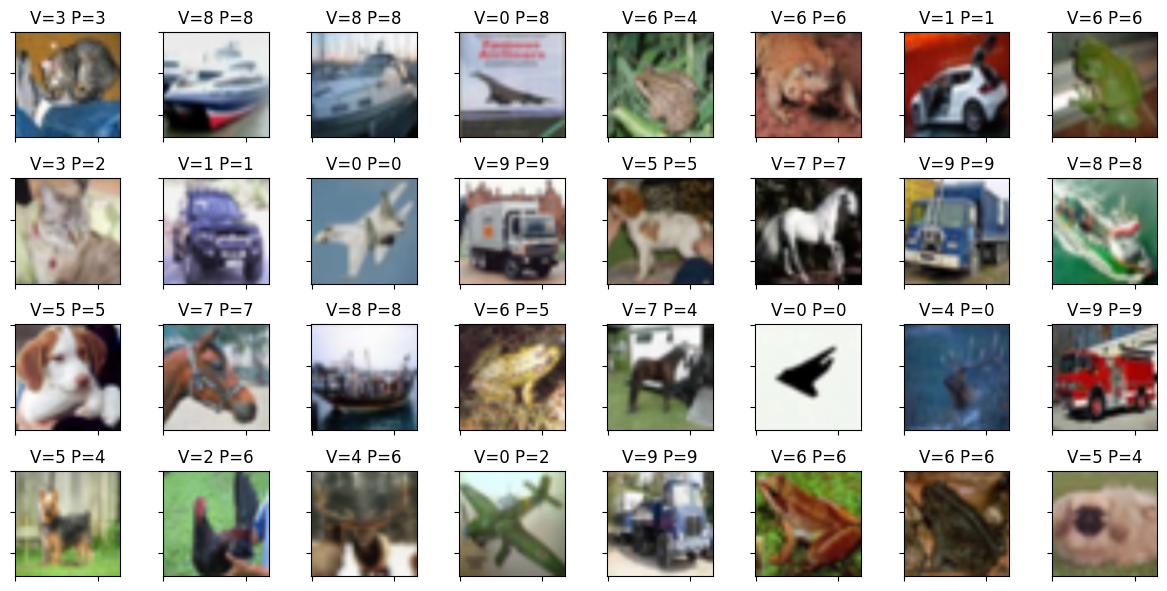

In [ ]:
with torch.no_grad():
    batch = next(iter(testloader))
    x, y_true = batch[0].to(device2), batch[1].to(device2)

    y_pred = torch.argmax(F.softmax(model(x.to(device2)).to(device), 1), 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x.to(device2), titles, ROWS, COLS)